# Прогнозирование заказов такси

**Цель работы:** Нужно спрогнозировать количество заказов такси на следующий час  

**Цель применния**: Чтобы привлекать больше водителей в период пиковой нагрузки

**Исходные данные**: Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. 

### Содержание:
* Импорт библиотек и данных. Подготовка данных
* Анализ данных
* Обучение разные моделей
* Тестирование
* Вывод


## Импорт библиотек и данных. Подготовка данных 

In [1]:
import pandas as pd # для работы с данными

import numpy as np # для работы с данными

import statsmodels.api as sm # для применения  функция adfuller()

from statsmodels.tsa.seasonal import seasonal_decompose # разложения радя на 3 состовляющие

import matplotlib.pyplot as plt # построение графиков

from sklearn.model_selection import train_test_split, GridSearchCV #для разделения выборок

from sklearn.linear_model import LinearRegression #lr

from sklearn.metrics import mean_squared_error #MSE

from lightgbm import LGBMRegressor # для работы с моделью LGBMRegressor

from sklearn.dummy import DummyRegressor# для работы с моделью DummyRegressor

from sklearn.ensemble import RandomForestRegressor # для работы с моделью RandomForestRegressor

import warnings # Параметры предупреждений
warnings.simplefilter('ignore')

from sklearn.model_selection import TimeSeriesSplit # кросс-валидация для times series


In [2]:
data = pd.read_csv('taxi.csv')
display(data.head())
display(data.describe())
display(data.info())

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


None

In [3]:
#Изменим тип данных datetime с object на datetime64, установим индекс таблицы равным столбцу datetime 
data = pd.read_csv('taxi.csv',
                   parse_dates=['datetime'],
                   index_col=['datetime'])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


True


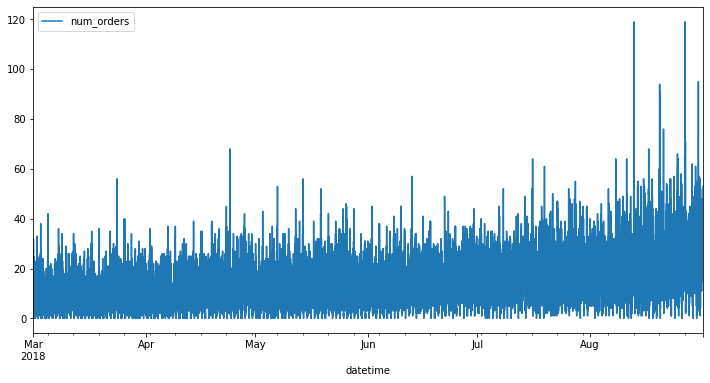

In [4]:
# расположим данные в хронологическом порядке
data.sort_index(inplace=True)
print(data.index.is_monotonic)
# посмортим график нашего ряда
data.plot(figsize=(12,6))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


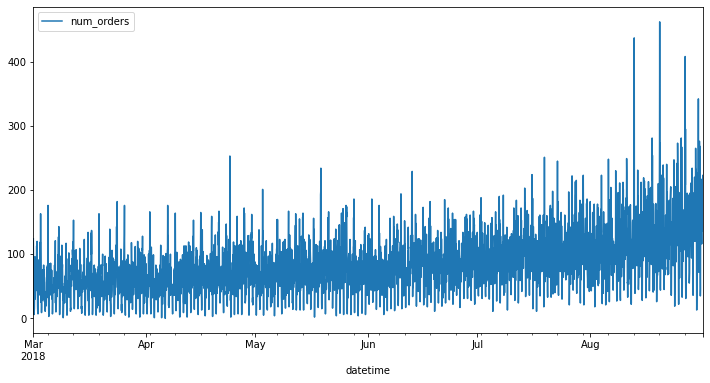

In [5]:
# Выполним ресемплирование данных по одному часу
data = data.resample('1H').sum()
data.plot(figsize=(12,6))
data.info()

 ### Промежуточный вывод

Данные загружены  
Отсортировали по хронологии, выполнили ресемплирование по часу  
Имеем данные с  начала марта по  конец августа 2018 года  


## Анализ данных


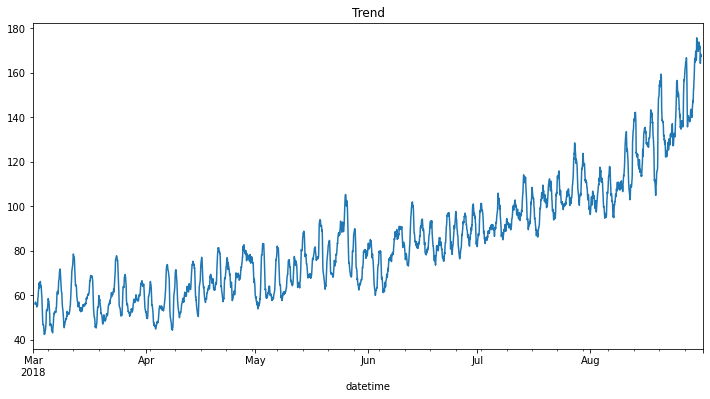

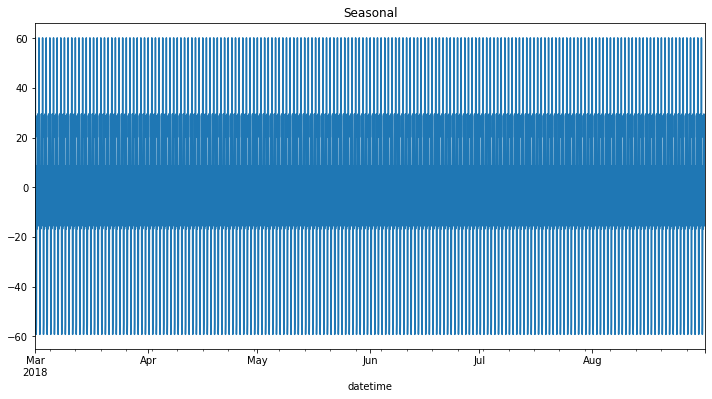

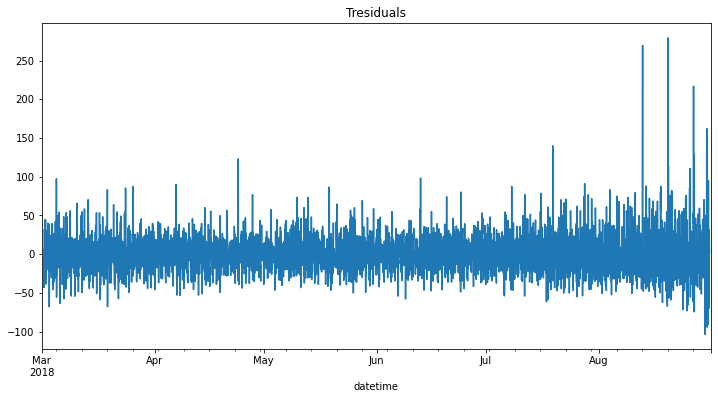

In [6]:
decomposed = seasonal_decompose(data['num_orders'])

trend = decomposed.trend
trend.plot(figsize=(12,6),ax=plt.gca())
plt.title('Trend')
plt.show()

seasonal = decomposed.seasonal
seasonal.plot(figsize=(12,6),ax=plt.gca())
plt.title('Seasonal')
plt.show()

residuals = decomposed.resid
residuals.plot(figsize=(12,6),ax=plt.gca())
plt.title('Tresiduals')
plt.show()

На графике тренда видно увеличение количество заказов такси с каждым месяцом.  
На графике сезонности видны повторяющиеся закономерности  в ряду. Слишком частая частота, необходимо рассмотреть более приблеженно.

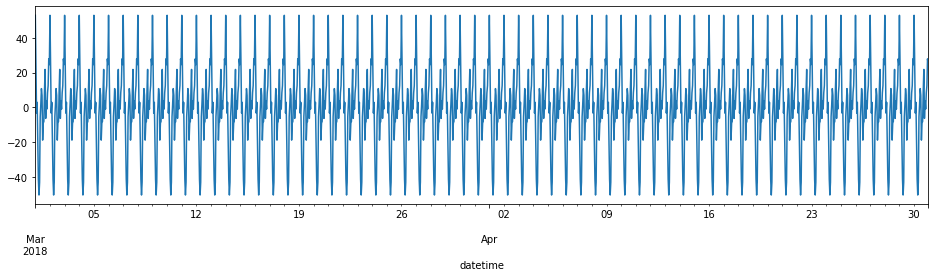

In [7]:
# Сезонность внутри 2 месяцев
plt.figure(figsize=(16,8))
decomposed_2month = seasonal_decompose(data['2018-03-01':'2018-04-30'])
plt.title('Сезонность')
plt.subplot(211)
decomposed_2month.seasonal.plot(ax=plt.gca())
plt.show()

Можно заметить повторяющиеся закономерности в ряду в течении каждого дня

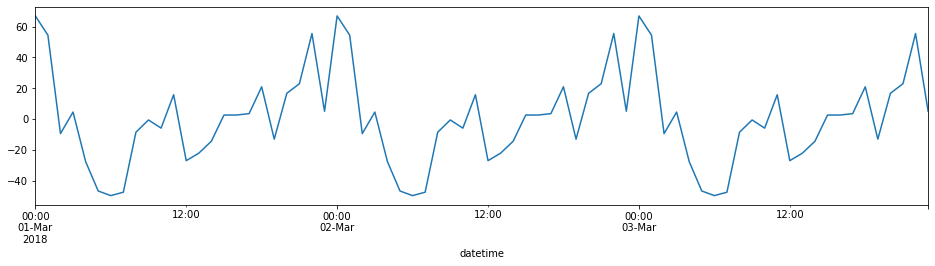

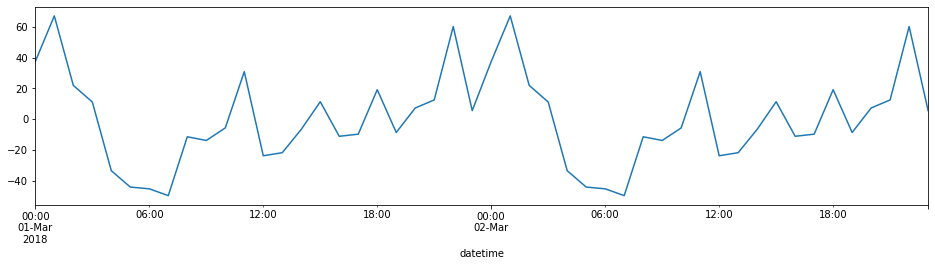

In [8]:
# Сезонность внутри 2 дней
plt.figure(figsize=(16,8))
decomposed_2day = seasonal_decompose(data['2018-03-01':'2018-03-03'])
plt.title('Сезонность')
plt.subplot(211)
decomposed_2day.seasonal.plot(ax=plt.gca())
plt.show()

# Сезонность внутри 1 дня
plt.figure(figsize=(16,8))
decomposed_1day = seasonal_decompose(data['2018-03-01':'2018-03-02'])
plt.title('Сезонность')
plt.subplot(211)
decomposed_1day.seasonal.plot(ax=plt.gca())
plt.show()

Теперь можно сказать - максимальная загрузка в районе 00:00, спад до ~06:00 (минимальная загрузка), с дальнейшем не плавным ростом до 00:00.  
Посмотрим как ведут себя недели в течении месяца

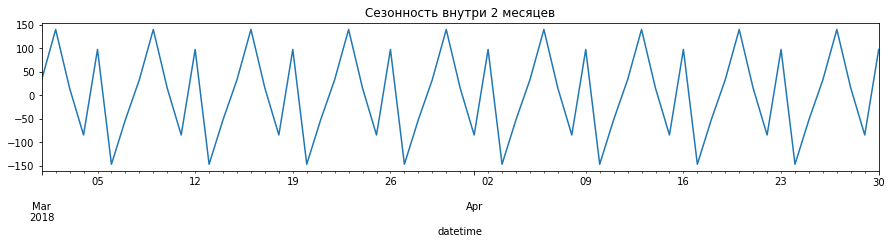

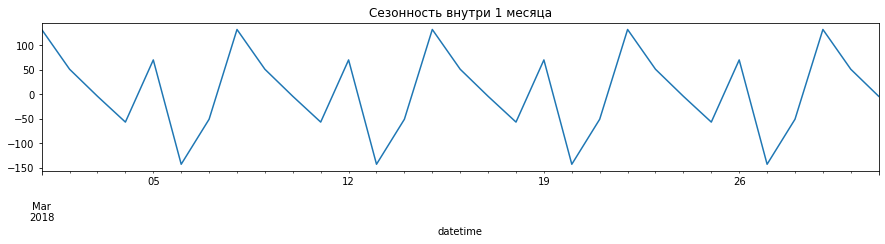

In [9]:
# Сезонность внутри 2 месяцев
plt.figure(figsize=(15, 6))
decomposed = seasonal_decompose(data['2018-03-01':'2018-04-30'].resample('1D').sum())
plt.subplot(211)
plt.title('Сезонность внутри 2 месяцев')
decomposed.seasonal.plot(ax=plt.gca())
plt.show()


# Сезонность внутри 1 месяца
plt.figure(figsize=(15, 6))
decomposed = seasonal_decompose(data['2018-03-01':'2018-03-31'].resample('1D').sum())
plt.subplot(211)
plt.title('Сезонность внутри 1 месяца')
decomposed.seasonal.plot(ax=plt.gca())
plt.show()

Теперь можно сказать - максимальная загрузка в понедельник( номер 0), минимальная загрузка - суббота( номер 06), очен хороший спрос в пятницу( номер 05)

Определили дневную сезонность - максимальная загрузка в понедельник, минимальная загрузка - суббота, очен хороший спрос в пятницу.
Определили суточную сезонность - максимальная загрузка в районе 00:00, спад до ~06:00 (минимальная загрузка), с дальнейшем не плавным ростом до 00:00.  
Про месячную сезонность  - нельзя ничего говорить, данные не за полный год.  
  Определили тренд -  рост с каждым месяцем. Но данные не полные, рост может быть связан с временем года.  
    
   
Шаг прогнозирования небольшой - примем все вышеуказанное как факт


## Обучение разных моделей 


In [10]:
def prepareData(data, lag_start=1, lag_end=24, test_size=0.1,rolling_mean_size=10):

    data_new = pd.DataFrame(data.copy())

    # создадим календарные признаки
    data['month'] = data_new.index.month
    data_new['day'] = data_new.index.day
    data_new['dayofweek'] = data_new.index.dayofweek
    data_new['hour'] = data_new.index.hour

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data['num_orders'].shift(i)
        
    # добавляем cкользящее среднее    
    data_new['rolling_mean'] = data_new['num_orders'].shift().rolling(rolling_mean_size).mean()    
    
    #Разобьем датасет на обучающую и тестовую выборки. Тестовую выборку делаем размером 10% от исходных данных
    train, test = train_test_split(data_new, shuffle=False, test_size=0.1)
    train = train.dropna()
        
    #Выделим признаки и целевой признак
    y_train = train['num_orders']
    X_train = train.drop('num_orders', axis=1)
    y_test = test['num_orders']
    X_test = test.drop('num_orders', axis=1)
    
    return X_train, X_test, y_train, y_test

### Константная модель

In [11]:
# исходные данные
X_train, X_test, y_train, y_test = prepareData(data, lag_start=1, lag_end=24, test_size=0.1)
        
model_const = DummyRegressor()
model_const.fit(X_train, y_train)
predicted = model_const.predict(X_train)
RMSE_const = round(mean_squared_error(y_train, predicted)**0.5)

print('DummyRegressor:RMSE -',RMSE_const)

DummyRegressor:RMSE - 39.0


### LinearRegression

In [12]:
# исходные данные
X_train, X_test, y_train, y_test = prepareData(data, lag_start=1, lag_end=24, test_size=0.1)

hyperparams = {'normalize' : [True, False]}
    
cv = TimeSeriesSplit(n_splits=3)

model_lr = LinearRegression()
lr_search = GridSearchCV(estimator = model_lr, param_grid=hyperparams, cv=cv, scoring='neg_mean_squared_error')
lr_search.fit(X_train, y_train)

RMSE_lr = (round(((lr_search.best_score_*(-1))**0.5),2))
print('LinearRegression:RMSE -',RMSE_lr)

LinearRegression:RMSE - 30.26


### LGBMRegressor

In [13]:
# исходные данные
X_train, X_test, y_train, y_test = prepareData(data, lag_start=1, lag_end=24, test_size=0.1)
    
# задаём параметры
hyperparams = [{'learning_rate':[i for i in np.geomspace(0.1,1.0,5)],
                'n_estimators' : range (100,1000,100),
                'max_depth': range (1,5,1)}]         

cv = TimeSeriesSplit(n_splits=3)

model_LGBM = LGBMRegressor( random_state = 12345)
gsearch = GridSearchCV(estimator = model_LGBM, cv=cv, param_grid=hyperparams, scoring='neg_mean_squared_error')
gsearch.fit(X_train, y_train)
RMSE_lgb = (round(((gsearch.best_score_*(-1))**0.5),2))
print('LGBMRegressor:RMSE -',RMSE_lgb)

LGBMRegressor:RMSE - 26.62


### RandomForestRegressor

In [14]:
# исходные данные
X_train, X_test, y_train, y_test = prepareData(data, lag_start=1, lag_end=24, test_size=0.1)
    
# задаём параметры
hyperparams = [{'n_estimators' : range (100,1000,100),
                'max_depth': range (1,5,1)}]         

cv = TimeSeriesSplit(n_splits=3)

model_rfr = RandomForestRegressor(random_state = 12345)
model_rfr_search = GridSearchCV(estimator = model_rfr, cv=cv, param_grid=hyperparams, scoring='neg_mean_squared_error')
model_rfr_search.fit(X_train, y_train)
RMSE_rfr = (round(((model_rfr_search.best_score_*(-1))**0.5),2))
print('RandomForestRegressor:RMSE -',RMSE_rfr)

RandomForestRegressor:RMSE - 31.93


 ### Промежуточный вывод

In [15]:
inter_result = pd.DataFrame([[RMSE_const],[RMSE_lr],[RMSE_lgb],[RMSE_rfr]],
                           columns = ['RMSE_train'],
                           index = ['DummyRegressor','LinearRegression','LGBMRegressor','RandomForestRegressor'])

inter_result

,RMSE_train
DummyRegressor,39.00
LinearRegression,30.26
LGBMRegressor,26.62
RandomForestRegressor,31.93



## Тестирование

### LinearRegression

In [16]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
predicted = model_lr.predict(X_test)
rmse_lr = mean_squared_error(y_test, predicted) ** 0.5
print(f'LinearRegression RMSE - {rmse_lr:.2f}')        


LinearRegression RMSE - 47.12


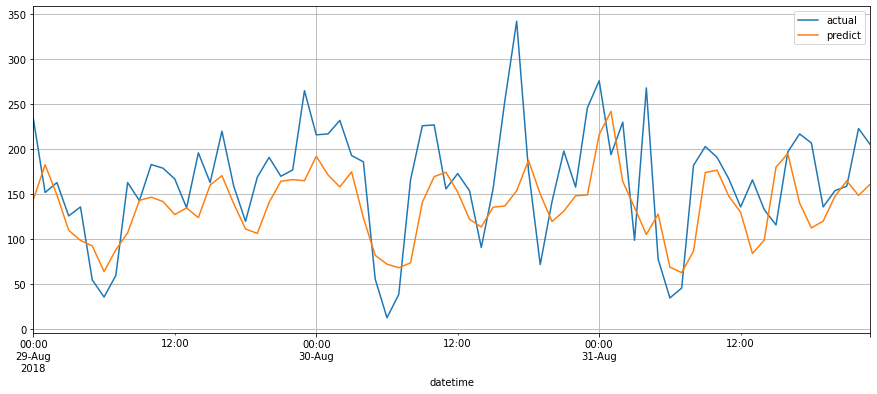

In [17]:
predict_series = pd.Series(predicted, index=y_test.index)
plt.figure(figsize=(15, 6))
y_test['2018-08-29':'2018-08-31'].plot(legend=True, label='actual')
predict_series['2018-08-29':'2018-08-31'].plot(legend=True, label='predict')
plt.grid(True)
plt.show()

### LGBMRegressor

In [18]:
gsearch_best_param = gsearch.best_params_
model_LGBM = LGBMRegressor(**gsearch_best_param, random_state = 12345)
model_LGBM.fit(X_train, y_train)
predicted_LGBM = model_LGBM.predict(X_test)
rmse_lgbm = mean_squared_error(y_test, predicted_LGBM) ** 0.5
print(f'LGBMRegressor RMSE  - {rmse_lgbm:.2f}') 

LGBMRegressor RMSE  - 41.43


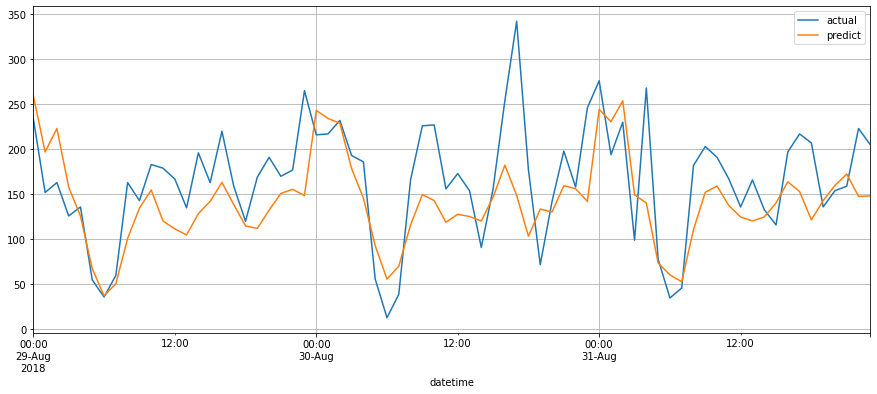

In [19]:
predict_series = pd.Series(predicted_LGBM, index=y_test.index)
plt.figure(figsize=(15, 6))
y_test['2018-08-29':'2018-08-31'].plot(legend=True, label='actual')
predict_series['2018-08-29':'2018-08-31'].plot(legend=True, label='predict')
plt.grid(True)
plt.show()

### RandomForestRegressor

In [20]:
model_rfr_search_best_param = model_rfr_search.best_params_
model_rfr = RandomForestRegressor(**model_rfr_search_best_param, random_state = 12345)
model_rfr.fit(X_train, y_train)
predicted_rfr = model_rfr.predict(X_test)
rmse_rfr = mean_squared_error(y_test, predicted_rfr) ** 0.5
print(f'RandomForestRegressor RMSE  - {rmse_rfr:.2f}')

RandomForestRegressor RMSE  - 54.40


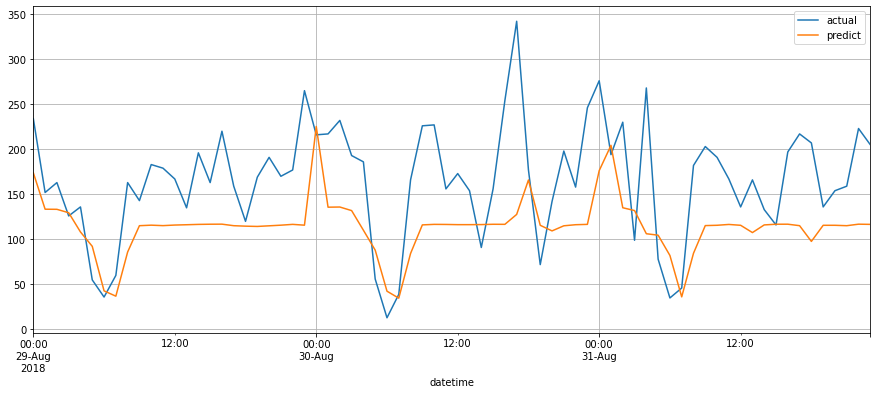

In [21]:
predict_series = pd.Series(predicted_rfr, index=y_test.index)
plt.figure(figsize=(15, 6))
y_test['2018-08-29':'2018-08-31'].plot(legend=True, label='actual')
predict_series['2018-08-29':'2018-08-31'].plot(legend=True, label='predict')
plt.grid(True)
plt.show()

In [22]:
final_result = pd.DataFrame([[rmse_lr],[rmse_lgbm],[rmse_rfr]],
                           columns = ['RMSE_test'],
                           index = ['LinearRegression','LGBMRegressor','RandomForestRegressor'])

final_result

,RMSE_test
LinearRegression,47.117069
LGBMRegressor,41.431700
RandomForestRegressor,54.400075



## Вывод 


Мы получили RMSE < 48  на моделях LinearRegression и LGBMRegressor